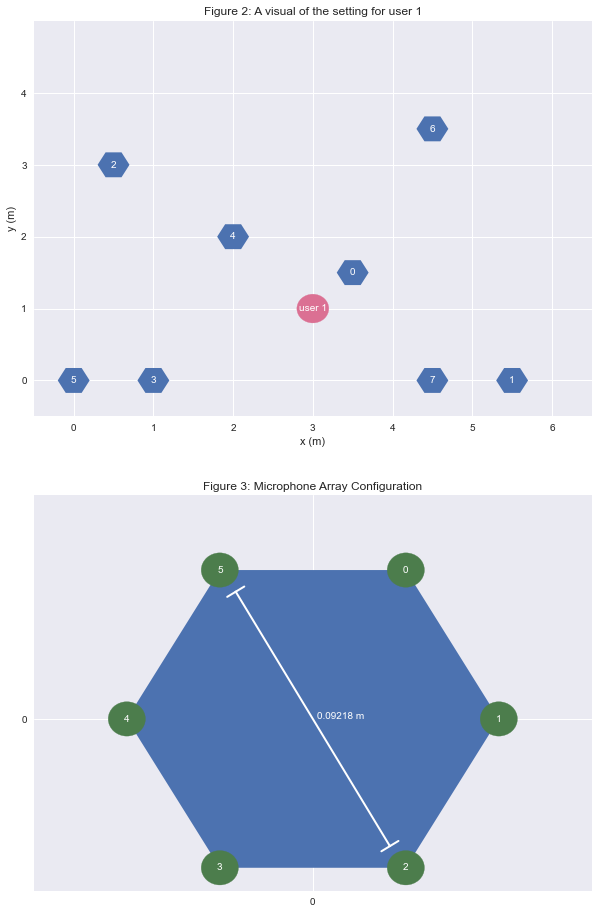

In [15]:
import numpy as np
import pandas as pd

if __name__ == '__main__':
    import matplotlib.pyplot as plt
    plt.style.use("seaborn") # This sets the matplotlib color scheme to something more soothing
    from IPython import get_ipython
    get_ipython().run_line_magic('matplotlib', 'inline')

# This function is used to format test results. You don't need to touch it.
def display_table(data):
    from IPython.display import HTML, display
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4><td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))
if __name__ == '__main__':
    array_locs = np.genfromtxt ('dataset0/config.csv', delimiter=",")
    user_1_location = np.array((3.0, 1.0))

    from matplotlib.patches import RegularPolygon, Circle
    fig, ax = plt.subplots(2, 1, figsize=(10,16))
    ax[0].set_title("Figure 2: A visual of the setting for user 1")
    ax[0].grid(b=True, which="major", axis="both")
    ax[0].set_xlim((-0.5, 6.5))
    ax[0].set_xticks(np.arange(0, 7))
    ax[0].set_xlabel("x (m)")
    ax[0].set_ylim((-0.5, 5))
    ax[0].set_yticks(np.arange(0, 5))
    ax[0].set_ylabel("y (m)")
    for (loc_num, (loc_x, loc_y)) in enumerate(array_locs, start=0):
        ax[0].add_patch(RegularPolygon(
            xy=(loc_x,loc_y), 
            numVertices=6, 
            radius=0.2, 
            orientation=np.pi/6
        ))
        ax[0].text(
            x=loc_x, 
            y=loc_y, 
            s=loc_num,
            color="white", 
            horizontalalignment="center",
            verticalalignment="center",
        )
    ax[0].add_patch(Circle(xy=user_1_location,radius=0.2, color="#DB7093"))
    ax[0].text(user_1_location[0], user_1_location[1], "user 1", color="white", ha="center", va="center")
    ax[1].set_title("Figure 3: Microphone Array Configuration")
    ax[1].grid(b=True, which="major", axis="both")
    ax[1].set_xlim((-1.5,1.5))
    ax[1].set_xticks([0])
    ax[1].set_ylim((-1.0,1.3))
    ax[1].set_yticks([0])
    ax[1].add_patch(RegularPolygon((0,0), 6, 1, np.pi/6))
    for mic_i in np.arange(6):
        mic_pos = np.e**(-1j * 2 * np.pi / 6 *  mic_i) \
            * np.e**(1j * 2 * np.pi / 6)
        ax[1].add_patch(Circle(
            xy=(mic_pos.real, mic_pos.imag),
            radius=0.1, 
            color="#4c7d4c"
        ))
        ax[1].text(
            x=mic_pos.real, 
            y=mic_pos.imag, 
            s=mic_i,
            color="white", 
            horizontalalignment="center",
            verticalalignment="center",
        )
    ax[1].annotate(
        "",
        xy=(0.42, -0.75),
        xytext=(-0.42, 0.75),
        arrowprops=dict(arrowstyle="|-|", color="white", lw=2)
    )
    ax[1].text(0.15, 0, "0.09218 m", color="white", ha="center")
    plt.show()

In [16]:
import math

def get_dataset(mic_data_folder):
    dataset = []
    for mic_num in np.arange(8):
        data = pd.read_csv(
            "{}/{}.csv".format(mic_data_folder, mic_num), 
            header=None
        )
        dataset.append(data.to_numpy())
    dataset = np.array(dataset)
    dataset = np.swapaxes(dataset, 1, 2)
    
    array_loc = np.genfromtxt(
        '{}/config.csv'.format(mic_data_folder), delimiter=","
    )
    array_loc = np.array(array_loc)
    return dataset, array_loc

def get_spectrum(mic_data_folder, FS, MIC_OFFSETS, grain=48):
    dataset, array_loc = get_dataset(mic_data_folder)
    
    AoA_spectrum = []
    for array in range(8):
        spectrum_per_array = []
        for theta_i in range(grain): #for every angle
            sample_offset= []

            theta = theta_i*360/grain

            hypt = 100 # hypotenuse = 20 meters
            adjc = hypt*math.cos(math.radians(theta)) # adjacent
            opps = hypt*math.sin(math.radians(theta)) # opposite

            mic_0_off_x, mic_0_off_y = MIC_OFFSETS[0]
            #print(xarray)

            mic_0_adjc = adjc - mic_0_off_x
            mic_0_opps = opps - mic_0_off_y
            mic_0_dist = math.sqrt(mic_0_adjc**2 + mic_0_opps**2) 

            for i in range(1, 6):
                mic_i_off_x, mic_i_off_y = MIC_OFFSETS[i]
                mic_i_adjc = adjc - mic_i_off_x
                mic_i_opps = opps - mic_i_off_y
                mic_i_dist = math.sqrt(mic_i_adjc**2 + mic_i_opps**2)

                delta_dist = mic_i_dist - mic_0_dist 
                # d > 0 if mic_i farther than mic 0
                # d < 0 if mic_i closer than mic 0

                samples_delay = round((delta_dist*16000)/343)
    #                 print('Mic 0 vs Mic %d delay %d samples'%(i, samples_delay))
                sample_offset.append(samples_delay)

            crop_offset = 1000
            S0 = dataset[array, 0, crop_offset:-crop_offset]
    #             print('Shape of S0:', S0.shape)

            dot_product = S0
            for i in range(5):
                starting_sample = crop_offset + sample_offset[i]
                ending_sample = -crop_offset + sample_offset[i]
                S = dataset[array, i+1, starting_sample:ending_sample]
                dot_product = np.dot(dot_product, S)

            spectrum_per_array.append(dot_product)
        AoA_spectrum.append(spectrum_per_array)
    AoA_spectrum = np.array(AoA_spectrum)
#     print(AoA_spectrum.shape)
    return AoA_spectrum, array_loc

def triangle(AoA_spectrum, array_loc, grain=48, res = 1):
    max_likelihood = 0
    max_x, max_y = 0, 0
    for j in range(res*5):
        for i in range(res*6):
            accumulated_likelihood = 0
            for array in range (8):
                mic_array_x, mic_array_y = array_loc[array, :]
                
                y = j/res
                x = i/res
                opps = y - mic_array_y
                adjc = x - mic_array_x + 0.00001
                tan = opps/adjc
                angle_in_radians = math.atan(tan)
                
                angle = round(math.degrees(angle_in_radians))
                
                if adjc < 0:
                    angle += 180
                elif opps < 0:
                    angle += 360
                angle = round(angle/(360/grain))
                if angle == grain:
                    angle = 0
#                 print(mic_array_x, mic_array_y, x, y, angle)
                accumulated_likelihood += AoA_spectrum[array][angle]
             
            if accumulated_likelihood > max_likelihood:
                max_likelihood = accumulated_likelihood
                max_x = x
                max_y = y
    return max_x, max_y

In [17]:
def aoa_localization(mic_data_folder, FS, MIC_OFFSETS):
    """AoA localization algorithm. Write your code here.

    Args:
        mic_data_folder: name of folder (without a trailing slash) containing 
                         the mic datafiles `0.csv` through `7.csv` and `config.csv`.
        FS: microphone sampling frequency - 16kHz.
        MIC_OFFSETS: a list of tuples of each microphone's location relative to the center of its mic array. 
                     This list is calculated based on the diameter(0.09218m) and geometry of the microphone array.
                     For example, MIC_OFFSETS[1] is [0.09218*0.5, 0]. If the location of microphone array #i is
                     [x_i, y_i]. Then [x_i, y_i] + MIC_OFFSETS[j] yields the absolute location of mic#j of array#i.
                     This is provided for your convenience and you may choose to ignore.

    Returns:
        The user's location in this format (in metres): (L_x, L_y)

    """

    # Your return value should be the user's location in this format (in metres): (L_x, L_y)
    angle_res = 48
    grid_res = 5
    total_spectrums, array_loc =get_spectrum(mic_data_folder, FS, MIC_OFFSETS, angle_res)
    userx, usery = triangle(total_spectrums, array_loc, angle_res, grid_res)
    print(userx, usery)
    return (userx, usery)


In [21]:
def calculate_score(calculated, expected):
    calculated = np.array(calculated)
    expected = np.array(expected)
    distance = np.linalg.norm(calculated - expected, ord=2)
    score = max(1 - (distance-1)/3, 0)
    return min(score, 1)

if __name__ == '__main__':
    test_folder_user_1 = 'user1_data'
    test_folder_user_2 = 'user2_data'
    groundtruth = [(3.0, 1.0), (4.0, 1.0), (3.0, 1.0), (4.0, 1.0)]
    MIC_OFFSETS = [(0.023,0.0399), (0.0461,0), (0.0230,-0.0399), (-0.0230,-0.0399), (-0.0461,0), (-0.0230,0.0399)]
    FS = 16000 # sampling frequency
    
    output = [['Dataset', 'Expected Output', 'Your Output']]
    for i in range(4):
        directory_name = 'dataset{}'.format(i)
        student_loc = aoa_localization(directory_name, FS, MIC_OFFSETS)
        score = calculate_score(student_loc, groundtruth[i])    
        output.append([
            str(i),
            str(groundtruth[i]), 
            str(student_loc), 
            #"{:2.2f}%".format(score * 100),
            #"{:1.2f} / 5.0".format(score * 5),
        ])

   
    display_table(output)

3.0 1.2
3.0 1.2
3.8 0.8
3.8 1.4
